# CYPLAN101 Fall 2025 - Lab 9: Park Site Selection Using Contextual Paradigms

## Learning Objectives:

By the end of this exercise, you will be able to:

1. Recognize how different geographic data types (vector and raster) provide context for spatial analysis
2. Create normalized indices from multiple criteria to evaluate site suitability
3. Combine vector data (points, polygons) with raster data (satellite imagery derivatives)
4. Use proximity analysis, raster calculations, and spatial joins
5. Identify optimal park locations based on environmental justice and accessibility criteria

---


You are a planning analyst tasked with identifying suitable locations for a new public park in Berkeley, California. Your analysis must consider three key criteria:

1. **Low Tree Canopy Coverage**: Areas with less existing tree cover may benefit more from a new park (environmental criterion)
2. **Lower Median Household Income**: Prioritize underserved communities with less access to green space (equity criterion)
3. **Proximity to AC Transit Stops**: Ensure the park is accessible via public transportation (accessibility criterion)

---


## Part 1: Setup and Data Loading

### Step 1: Install and Import Required Libraries

We'll need several Python libraries for spatial analysis:

- `geopandas`: For vector data manipulation
- `rasterio`: For raster data processing
- `rasterstats`: For extracting raster statistics to vector features
- `matplotlib` and `contextily`


In [32]:
# Install required packages
%pip install -r requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.


In [33]:
# Import libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats
import warnings
from census import Census

warnings.filterwarnings("ignore")

### Step 2: Load Berkeley Boundary

First, we'll load the boundary of Berkeley to define our study area. We'll use Census data from the US Census Bureau.


In [34]:
# Load Berkeley city boundary from Census TIGER/Line
# Using the Census Places shapefile for California
url = "https://www2.census.gov/geo/tiger/TIGER2023/PLACE/tl_2023_06_place.zip"

# Read all California places
ca_places = gpd.read_file(url)

# Filter for Berkeley
berkeley = ca_places[ca_places["NAME"] == "Berkeley"].copy()

# Reproject to appropriate CRS (California State Plane Zone 3, NAD83)
berkeley = berkeley.to_crs(epsg=26943)

print("Berkeley boundary loaded successfully!")
print(f"CRS: {berkeley.crs}")
print(f"Area: {berkeley.geometry.area.values[0] / 1_000_000:.2f} square kilometers")

berkeley.head()

Berkeley boundary loaded successfully!
CRS: EPSG:26943
Area: 45.72 square kilometers


,STATEFP,PLACEFP,PLACENS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,PCICBSA,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
355,06,06000,02409837,0606000,1600000US0606000,Berkeley,Berkeley city,25,C1,Y,G4110,A,27018309,18712737,+37.8656733,-122.2987247,"POLYGON ((1835673.966 653320.83, 1836653.954 6..."


### Step 3: Visualize Study Area


##❗️ Try it Out ❗️
Create a simple map of Berkeley. How does this boundary compare with the boundary we downloaded directly from the city of Berkeley website?


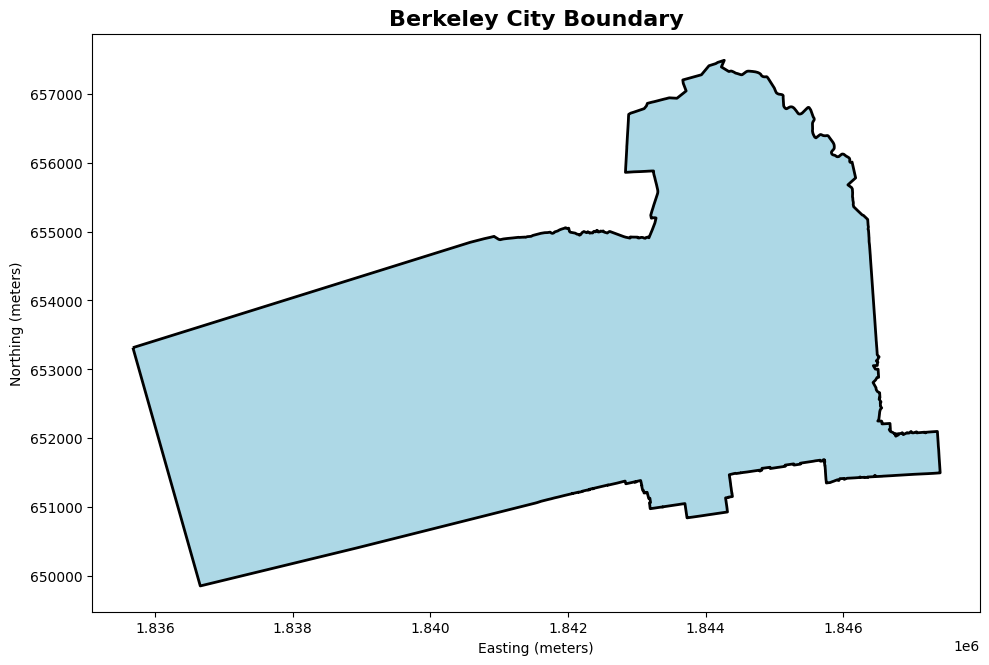

In [35]:
# Run the code cell below
fig, ax = plt.subplots(figsize=(10, 10))
berkeley.plot(ax=ax, color="lightblue", edgecolor="black", linewidth=2)
ax.set_title("Berkeley City Boundary", fontsize=16, fontweight="bold")
ax.set_xlabel("Easting (meters)")
ax.set_ylabel("Northing (meters)")
plt.tight_layout()
plt.show()

---

## Part 2: Load and Process Criteria Data

### Step 1: Tree Canopy Coverage (Criterion 1; Raster Data)

We'll use NLCD (National Land Cover Database) tree canopy data. Since we want to identify areas with **low** tree canopy coverage (areas that would benefit from a new park), we'll need to invert this criterion.

We'll use NLCD (National Land Cover Database) Tree Canopy Cover data for Berkeley. This dataset shows the percentage of tree canopy cover at 30-meter resolution. We want to identify areas with low tree canopy coverage, as these areas would benefit most from a new park with additional trees and green space.
Dataset Information:

- Source: USGS NLCD Tree Canopy Cover (v2023-5)
- Year: 2023
- Resolution: 30 meters
- CRS: Albers Conical Equal Area
- Values: 0-100% tree canopy coverage (255 = NoData)

> **Tip:** You can retrieve land cover and tree canopy coverage data from the NCLD using the **Multi-Resolution Land Characteristis Consortiom's [NCLD Viewer](https://www.mrlc.gov/viewer/)** tool.


##❗️ Try it Out ❗️
In this step you will upload and access a GeoTIFF file from the NLCD database. To complete this step, you must download the GeoTIFF from bCourses. This GeoTIFF file has already been clipped to the City of Berkeley.


In [36]:
# Insert the path to the GeoTIFF containing the most recent year available (2023)
nlcd_path = "data/nlcd_tcc_conus_wgs84_v2023-5_20220101_20221231_mhc0w2r4y2d99m.tiff"

# Open the raster with rasterio and uncomment the lines below to read metadata for your raster data
with rasterio.open(nlcd_path) as canopy:
    # Read metadata
    print("NLCD Tree Canopy Cover - Raster Information:")
    print("=" * 60)
    print(f"CRS: {canopy.crs}")
    print(f"Shape (rows, cols): {canopy.shape}")
    print(f"Resolution: {canopy.res[0]} x {canopy.res[1]} meters")
    print(f"Bounds: {canopy.bounds}")
    print(f"NoData value: {canopy.nodata}")

    # Read the raster data
    canopyData = canopy.read(1)
    canopyTransform = canopy.transform
    canopyCrs = canopy.crs

    # Calculate statistics (excluding NoData values)
    validData = canopyData[canopyData != canopy.nodata]

    print("\nTree Canopy Coverage Statistics:")
    print("=" * 60)
    print(f"Valid pixels: {len(validData):,}")
    print(f"Mean canopy coverage: {validData.mean():.1f}%")
    print(f"Median canopy coverage: {np.median(validData):.1f}%")
    print(f"Min: {validData.min():.1f}%")
    print(f"Max: {validData.max():.1f}%")
    print(f"Std Dev: {validData.std():.1f}%")

NLCD Tree Canopy Cover - Raster Information:
CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Shape (rows, cols): (452, 537)
Resolution: 30.0 x 30.0 meters
Bounds: BoundingBox(left=-2268135.0, bottom=1953165.0, right=-2252025.0, top=1966725.0)
NoData value: 255.0

Tree Canopy Coverage Statistics:
Valid pixels: 157,588
Mean canopy coverage: 14.7%
Median canopy coverage: 0.0%
Min: 0.0%
Max: 85.0%
Std Dev: 19.3%


Create a visualization of the tree canopy cover. You may use the code cell below as a reference for additional plots throughout this lab exercise.


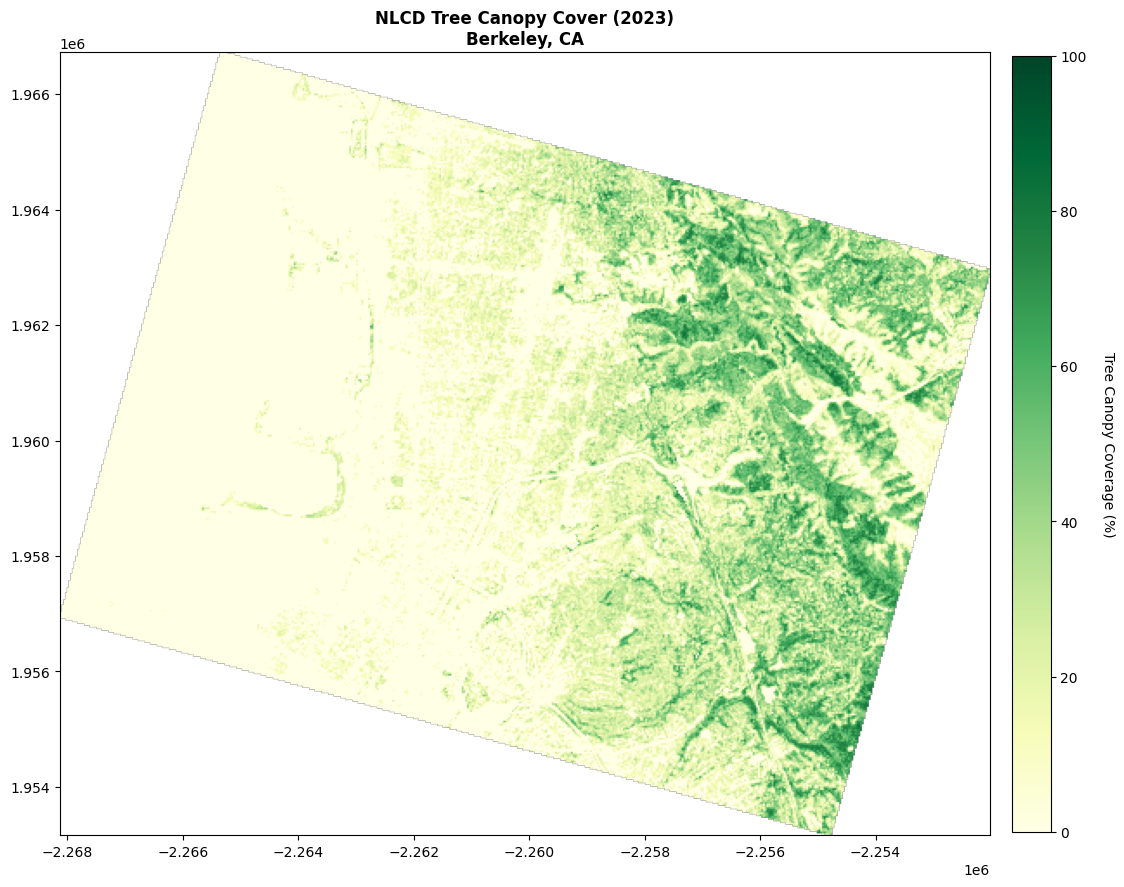

In [37]:
# Create a visualization of the tree canopy cover
fig, ax = plt.subplots(figsize=(12, 10))

# Create a masked array to handle NoData values
canopyMasked = np.ma.masked_where(canopyData == 255, canopyData)

# Plot the raster
show(
    canopyMasked,
    transform=canopyTransform,
    ax=ax,
    cmap="YlGn",
    vmin=0,
    vmax=100,
    title="NLCD Tree Canopy Cover (2023)\nBerkeley, CA",
)

# Add colorbar
im = ax.images[0]
cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.02, shrink=0.8)
cbar.set_label("Tree Canopy Coverage (%)", rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

### Step 2: Extract Tree Canopy Statistics to Census Tracts

Now we'll use **zonal statistics** to calculate the mean tree canopy coverage for each census tract. This allows us to aggregate raster values (continuous tree canopy data) to vector polygons (discrete census tracts).

To do this, first you will need to load in vector data:

```
# Load census tract polygons
<vector_gdf> = gpd.read_file(<vector_file_path>)
```

Second, you will need to reproject to match the raster's CRS:

```
# Reproject vector data to match raster coordinate reference system
<vector_gdf_reprojected> = <vector_gdf>.to_crs(<raster_crs>)
```

Third, you will need to calculate zonal statistics

```
# Extract statistics from raster for each polygon zone
<stats> = zonal_stats(
    <vector_gdf_reprojected>,
    <raster_file_path>,
    stats=[<list_of_statistics>],
    nodata=<nodata_value>
)
```

Fourth, you will need to append the result to a GeoDataFrame

```
# Add calculated statistics as new columns
<vector_gdf>['<new_column_name>'] = [s['<statistic>'] if s['<statistic>'] is not None else <default_value> for s in <stats>]
```


##❗️ Try it Out ❗️
Let's apply what we have learned and aggregate the tree canopy coverage to Berkeley census tracts.

To complete this step you will need to find a way to import your Berkeley Census Tracts dataset including the Median Household Income column.


In [38]:
# Edit the code cell below to load in your Berkeley Census Tracts Data
berkeleyTracts = gpd.read_file("data/berkeleyCensusGdf.gpkg")

# # Edit the code cell below to ensure census tracts are in the same CRS as the raster
berkeleyTractsAlbers = berkeleyTracts.to_crs(canopy.crs)

# Calculate zonal statistics using rasterstats
# This extracts mean tree canopy percentage for each census tract
stats = zonal_stats(
    berkeleyTractsAlbers, nlcd_path, stats=["mean", "min", "max", "median"], nodata=255
)

# Add statistics to the GeoDataFrame
berkeleyTracts["tree_canopy_pct"] = [
    s["mean"] if s["mean"] is not None else 0 for s in stats
]
berkeleyTracts["canopy_min"] = [s["min"] if s["min"] is not None else 0 for s in stats]
berkeleyTracts["canopy_max"] = [s["max"] if s["max"] is not None else 0 for s in stats]
berkeleyTracts["canopy_median"] = [
    s["median"] if s["median"] is not None else 0 for s in stats
]

# Uncomment and run the following code to view summary statistics
print("Tree Canopy Coverage by Census Tract:")
print("=" * 60)
print(f"Mean across all tracts: {berkeleyTracts['tree_canopy_pct'].mean():.1f}%")
print(f"Median across all tracts: {berkeleyTracts['tree_canopy_pct'].median():.1f}%")
print(f"Min tract coverage: {berkeleyTracts['tree_canopy_pct'].min():.1f}%")
print(f"Max tract coverage: {berkeleyTracts['tree_canopy_pct'].max():.1f}%")
print(f"Std Dev: {berkeleyTracts['tree_canopy_pct'].std():.1f}%")

Tree Canopy Coverage by Census Tract:
Mean across all tracts: 10.3%
Median across all tracts: 7.5%
Min tract coverage: 0.0%
Max tract coverage: 35.3%
Std Dev: 8.5%


<Figure size 1500x1000 with 0 Axes>

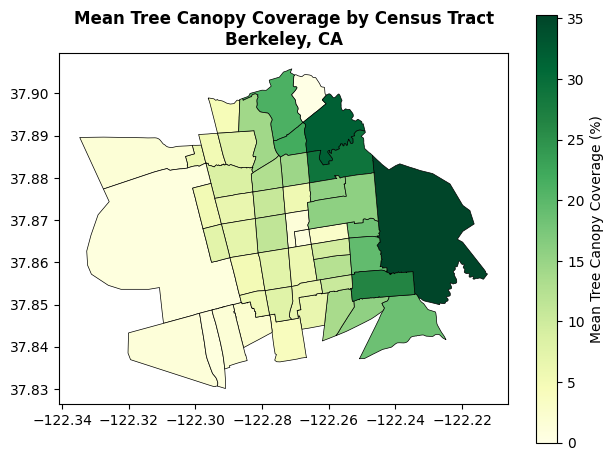

In [39]:
# Use the space below to create a plot of tree canopy coverage by census tract
plt.figure(figsize=(15, 10))
berkeleyTracts.plot(
    column="tree_canopy_pct",
    cmap="YlGn",
    legend=True,
    legend_kwds={"label": "Mean Tree Canopy Coverage (%)"},
    edgecolor="black",
    linewidth=0.5,
)
plt.title(
    "Mean Tree Canopy Coverage by Census Tract\nBerkeley, CA",
    fontsize=12,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

##❗️ Try it Out ❗️
Use the space below to join a Median Household Income series to your Berkeley Tracts GeoDataFrame if you have not already

> **Hint:** If you are having difficulty accessing census data, please refer to the Lab 6 and 9 course files.


In [40]:
# Use the space below to join a MHHI series to your Berkeley Tracts GeoDataFrame.
POPULATION_FIELD = "B01003_001E"
MEDIAN_INCOME_FIELD = "B19013_001E"

neg_incomes = sum(berkeleyTracts.B19013_001E < 0)
print(f"Total tracts with missing incomes: {neg_incomes}")

# Filter our negative (missing) median income(s)
berkeleyTracts[MEDIAN_INCOME_FIELD] = berkeleyTracts[MEDIAN_INCOME_FIELD].apply(
    lambda row: 0 if row < 0 else row
)

neg_incomes = sum(berkeleyTracts.B19013_001E < 0)
print(f"Total tracts now with missing incomes: {neg_incomes}")

berkeleyTracts.to_file("data/berkeleyCensusGdf_with_canopy.gpkg", driver="GPKG")
print("Berkeley Census Tracts with Tree Canopy data saved to 'data/berkeleyCensusGdf_with_canopy.gpkg'")

Total tracts with missing incomes: 2
Total tracts now with missing incomes: 0
Berkeley Census Tracts with Tree Canopy data saved to 'data/berkeleyCensusGdf_with_canopy.gpkg'


<Figure size 1500x1000 with 0 Axes>

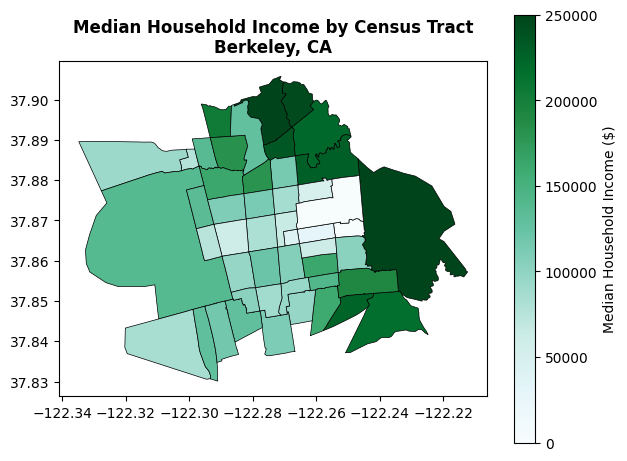

In [41]:
# When done, produce a plot of median household income by tract
plt.figure(figsize=(15, 10))
berkeleyTracts.plot(
    column=MEDIAN_INCOME_FIELD,
    cmap="BuGn",
    legend=True,
    legend_kwds={"label": "Median Household Income ($)"},
    edgecolor="black",
    linewidth=0.5,
)
plt.title(
    "Median Household Income by Census Tract\nBerkeley, CA",
    fontsize=12,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

### Step 4: Criterion 3: Proximity to AC Transit Stops (Vector Point Data)

We'll load AC Transit bus stop locations and calculate proximity. Navigate to the **[AC Transit Data and API Resources](https://www.actransit.org/data-api-resource-center)** site and download the stop data shapefile.

> **Tip:** If you experience difficulty accessing this file, you can also find it in the Lab 9 course files.


In [42]:
# Read AC Transit stops from uploaded shapefile
# Students: Upload the AC Transit stops shapefile zip file to your environment

# Read the shapefile (GeoPandas can read directly from a zip file)
transitStops = gpd.read_file("data/UniqueStops_Fall25.zip")
original_crs = transitStops.crs
print(f"Original CRS of transit stops: {original_crs}")

# Reproject stops to match berkeley CRS
transitStops = transitStops.to_crs(berkeley.crs) #type:ignore

# Clip to Berkeley boundary
transitStopsCal = gpd.sjoin(transitStops, berkeley, how="inner", predicate="within")

# Keep relevant columns (use double brackets for multiple columns)
transitStopsCal = transitStopsCal[
    ["OBJECTID", "stp_identi", "stp_511_id", "stp_descri", "route", "geometry"]
].copy()

# Remove duplicate stops (from spatial join)
transitStopsCal = transitStopsCal.drop_duplicates(subset="stp_identi")

print(f"Found {len(transitStopsCal)} AC Transit stops within Berkeley")
transitStopsCal.head()

Original CRS of transit stops: EPSG:4326
Found 503 AC Transit stops within Berkeley


,OBJECTID,stp_identi,stp_511_id,stp_descri,route,geometry
229,230,0300210,55909,7th St & Anthony St,36,POINT (1842344.025 651587.371)
230,231,0300220,55915,7th St & Anthony St,36,POINT (1842364.046 651575.265)
231,232,0300260,55970,7th St & Grayson St,36,POINT (1842262.565 651936.181)
232,233,0300270,50633,7th St & Grayson St,36,POINT (1842266.414 651953.335)
233,234,0300290,58667,7th St & Heinz Av,36,POINT (1842332.378 651704.039)


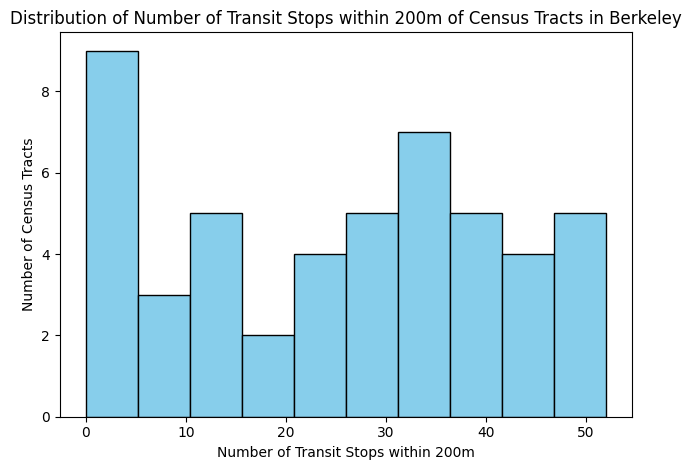

In [48]:
projected_crs = berkeley.crs
# Reproject transit stops and tracts to a projected CRS (meters) before buffering
transitStopsCal = transitStopsCal.to_crs(projected_crs)  # type:ignore
berkeleyTracts = berkeleyTracts.to_crs(projected_crs)

buffer_radius = 200  # meters (now valid because CRS units are meters)
stops_buffered = transitStopsCal.copy()
stops_buffered["geometry"] = stops_buffered.geometry.buffer(buffer_radius)

stops_to_tracts = gpd.sjoin(
    stops_buffered,
    berkeleyTracts,
    how="inner",
    predicate="intersects",
    lsuffix="stop",
    rsuffix="tract",
)

stop_counts_by_tract = stops_to_tracts.groupby("GEOID").size().reset_index(name="num_buffered_stops")

berkeleyTracts_with_counts = berkeleyTracts.merge(
    stop_counts_by_tract,
    on="GEOID",
    how="left"
)

# For tracts with no nearby stops, fill NaN with 0
berkeleyTracts_with_counts["num_buffered_stops"] = (
    berkeleyTracts_with_counts["num_buffered_stops"]
    .fillna(0)
    .astype(int)
)

plt.hist(berkeleyTracts_with_counts["num_buffered_stops"],color='skyblue', edgecolor='black')
plt.title("Distribution of Number of Transit Stops within 200m of Census Tracts in Berkeley")
plt.xlabel("Number of Transit Stops within 200m")
plt.ylabel("Number of Census Tracts")
plt.tight_layout()
plt.show()

<Figure size 1500x1000 with 0 Axes>

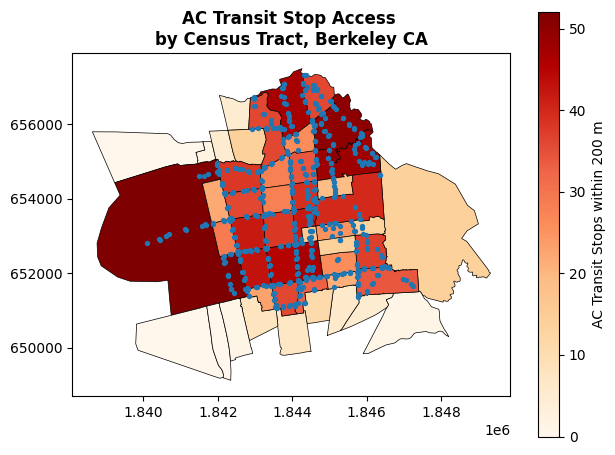

In [44]:
# When done, edit the template code below to produce a plot of stops by tract
plt.figure(figsize=(15, 10))

# Choropleth: number of buffered stops per tract
berkeleyTracts_with_counts.plot(
    column="num_buffered_stops",
    cmap="OrRd",
    legend=True,
    legend_kwds={"label": "AC Transit Stops within 200 m"},
    edgecolor="black",
    linewidth=0.5,
)

# Scatter: actual AC Transit stop locations
transitStopsCal.to_crs(berkeleyTracts_with_counts.crs).plot(
    markersize=8,
    ax=plt.gca(),
)

plt.title(
    "AC Transit Stop Access \nby Census Tract, Berkeley CA",
    fontsize=12,
    fontweight="bold",
)

plt.tight_layout()
plt.show()

In [45]:
berkeleyTracts_with_counts.to_file("data/berkeleyCensusGdf_with_stops_and_canopy.gpkg", driver="GPKG")